# Building and deploying machine learning solutions with Vertex AI

## Scenario

We use a movie review dataset to create and deploy a model onto the cloud. These predictions will be used as an input in downstream later on. We deploy a custom TensorFlow BERT sentiment classifier for online predictions on Google Cloud's [Vertex AI](https://cloud.google.com/vertex-ai) platform. Vertex AI is Google Cloud's next generation machine learning development platform where you can leverage the latest ML pre-built components and AutoML to significantly enhance your development productivity, scale your workflow and decision making with your data, and accelerate time to value.

## Setup

### Define constants

In [1]:
# Add installed library dependencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

env: PATH=C:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\tfx\.vertexenv\Scripts;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Docker\Docker\resources\bin;C:\Program Files\dotnet\;C:\Program Files (x86)\Google\Cloud SDK\google-cloud-sdk\bin;C:\Users\volte\AppData\Local\Programs\Microsoft VS Code\bin;C:\Users\volte\AppData\Local\GitHubDesktop\bin;C:\Users\volte\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0;:/home/jupyter/.local/bin


In [ ]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = "ml-deployments-practice"
REGION = "europe-west1"

In [3]:
GCS_BUCKET = "gs://vertex_test131412416"

In [4]:
!gsutil mb -l $REGION $GCS_BUCKET

Creating gs://vertex_test131412416/...
ServiceException: 409 A Cloud Storage bucket named 'vertex_test131412416' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Import libraries

In [5]:
import os
import shutil
import logging

# TensorFlow model building libraries.
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

# Re-create the AdamW optimizer used in the original BERT paper.
from official.nlp import optimization  

# Libraries for data and plot model training metrics.
import pandas as pd
import matplotlib.pyplot as plt

# Import the Vertex AI Python SDK.
from google.cloud import aiplatform as vertexai

# Install pydot and graphviz
!pip install pydot
!pip install graphviz 

C:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\tfx\.vertexenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\tfx\.vertexenv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Initialize Vertex AI Python SDK

Initialize the Vertex AI Python SDK with your GCP Project, Region, and Google Cloud Storage Bucket.

In [6]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

## Build and train your model locally in a Vertex Notebook

### Import dataset

In [7]:
DATA_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
LOCAL_DATA_DIR = "."

In [8]:
def download_data(data_url, local_data_dir):
    """Download dataset.
    Args:
      data_url(str): Source data URL path.
      local_data_dir(str): Local data download directory path.
    Returns:
      dataset_dir(str): Local unpacked data directory path.
    """
    if not os.path.exists(local_data_dir):
        os.makedirs(local_data_dir)
    
    dataset = tf.keras.utils.get_file(
      fname="aclImdb_v1.tar.gz",
      origin=data_url,
      untar=True,
      cache_dir=local_data_dir,
      cache_subdir="")
    
    dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
    
    train_dir = os.path.join(dataset_dir, "train")
    
    # Remove unused folders to make it easier to load the data.
    remove_dir = os.path.join(train_dir, "unsup")
    shutil.rmtree(remove_dir)
    
    return dataset_dir

In [9]:
DATASET_DIR = download_data(data_url=DATA_URL, local_data_dir=LOCAL_DATA_DIR)

In [10]:
# Create a dictionary to iteratively add data pipeline and model training hyperparameters.
HPARAMS = {
    # Set a random sampling seed to prevent data leakage in data splits from files.
    "seed": 42,
    # Number of training and inference examples.
    "batch-size": 32
}

In [11]:
def load_datasets(dataset_dir, hparams):
    """Load pre-split tf.datasets.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      raw_train_ds(tf.dataset): Train split dataset (20k examples).
      raw_val_ds(tf.dataset): Validation split dataset (5k examples).
      raw_test_ds(tf.dataset): Test split dataset (25k examples).
    """    

    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='training',
        seed=hparams['seed'])    

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='validation',
        seed=hparams['seed'])

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        batch_size=hparams['batch-size'])
    
    return raw_train_ds, raw_val_ds, raw_test_ds

In [12]:
raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(DATASET_DIR, HPARAMS)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = raw_train_ds.class_names

train_ds = raw_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.prefetch(buffer_size=AUTOTUNE)

Let's print a few example reviews:

In [14]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review {i}: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({CLASS_NAMES[label]})')

Review 0: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review 1: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as 

### Choose a pre-trained BERT model to fine-tune for higher accuracy

[**Bidirectional Encoder Representations from Transformers (BERT)**](https://arxiv.org/abs/1810.04805v2) is a transformer-based text representation model pre-trained on massive datasets (3+ billion words) that can be fine-tuned for state-of-the art results on many natural language processing (NLP) tasks. Since release in 2018 by Google researchers, its has transformed the field of NLP research and come to form a core part of significant improvements to [Google Search](https://www.blog.google/products/search/search-language-understanding-bert). 

The Small BERT models are instances of the original BERT architecture with a smaller number L of layers (i.e., residual blocks) combined with a smaller hidden size H and a matching smaller number A of attention heads, as published by

They have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.

The following preprocessing and encoder models in the TensorFlow 2 SavedModel format use the implementation of BERT from the [TensorFlow Models Github repository](https://github.com/tensorflow/models/tree/master/official/nlp/bert) with the trained weights released by the authors of Small BERT.

In [15]:
HPARAMS.update({
    # TF Hub BERT modules.
    "tfhub-bert-preprocessor": "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "tfhub-bert-encoder": "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
})

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. Since this text preprocessor is a TensorFlow model, It can be included in the model directly.

For the learning rate `initial-learning-rate`, the same schedule as BERT pre-training is used: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps `n_warmup_steps`. In line with the BERT paper, the initial learning rate is smaller for fine-tuning.

In [16]:
HPARAMS.update({
    # Model training hyperparameters for fine tuning and regularization.
    "epochs": 3,
    "initial-learning-rate": 3e-5,
    "dropout": 0.1 
})

In [17]:
epochs = HPARAMS['epochs']
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
n_train_steps = steps_per_epoch * epochs
n_warmup_steps = int(0.1 * n_train_steps)    

OPTIMIZER = optimization.create_optimizer(init_lr=HPARAMS['initial-learning-rate'],
                                          num_train_steps=n_train_steps,
                                          num_warmup_steps=n_warmup_steps,
                                          optimizer_type='adamw')

### Build and compile a TensorFlow BERT sentiment classifier

In [18]:
def build_text_classifier(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      model(tf.keras.Model): A compiled TensorFlow model.
    """
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # Add a hub.KerasLayer for BERT text preprocessing using the hparams dict. 
    # Name the layer 'preprocessing' and store in the variable 'preprocessor'.
    preprocessor = hub.KerasLayer(hparams['tfhub-bert-preprocessor'], name='preprocessing')
    
    encoder_inputs = preprocessor(text_input)
    
    # Access the encoder URL from the hparams dictionary
    encoder = hub.KerasLayer(hparams['tfhub-bert-encoder'], trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    
    # For the fine-tuning you are going to use the `pooled_output` array which represents 
    # each input sequence as a whole. The shape is [batch_size, H]. 
    # You can think of this as an embedding for the entire movie review.
    classifier = outputs['pooled_output']
    
    # Add dropout to prevent overfitting during model fine-tuning.
    classifier = tf.keras.layers.Dropout(hparams['dropout'], name='dropout')(classifier)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier)
    
    model = tf.keras.Model(text_input, classifier, name='bert-sentiment-classifier')
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = [tf.metrics.BinaryAccuracy()]    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)    
    
    
    return model

In [19]:
model = build_text_classifier(HPARAMS, OPTIMIZER)

In [21]:
# Visualize your fine-tuned BERT sentiment classifier.
#tf.keras.utils.plot_model(model)

In [22]:
TEST_REVIEW = ['this is such an amazing movie!']

In [23]:
BERT_RAW_RESULT = model(tf.constant(TEST_REVIEW))
print(BERT_RAW_RESULT)

tf.Tensor([[-0.52535594]], shape=(1, 1), dtype=float32)


### Training and evaluating the BERT sentiment classifier

In [24]:
HPARAMS.update({
    # TODO: Save your BERT sentiment classifier locally in the form of <key>:<path to save the model>. 
    # Hint: You can use the key as 'model-dir' and save it to './bert-sentiment-classifier-local'.
    'model-dir' : './bert-sentiment-classifier-local'
    
})

In [25]:
def train_evaluate(hparams):
    """Train and evaluate TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    # dataset_dir = download_data(data_url, local_data_dir)
    raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(DATASET_DIR, hparams)
    
    train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)     
    
    epochs = hparams['epochs']
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    n_train_steps = steps_per_epoch * epochs
    n_warmup_steps = int(0.1 * n_train_steps)    
    
    optimizer = optimization.create_optimizer(init_lr=hparams['initial-learning-rate'],
                                              num_train_steps=n_train_steps,
                                              num_warmup_steps=n_warmup_steps,
                                              optimizer_type='adamw')    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = build_text_classifier(hparams=hparams, optimizer=optimizer)
    
    logging.info(model.summary())
        
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)  
    
    logging.info("Test accuracy: %s", model.evaluate(test_ds))

    # Export Keras model in TensorFlow SavedModel format.
    model.save(hparams['model-dir'])
    
    return history

In [26]:
history = train_evaluate(HPARAMS)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "bert-sentiment-classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                              

INFO:tensorflow:Assets written to: ./bert-sentiment-classifier-local\assets


INFO:tensorflow:Assets written to: ./bert-sentiment-classifier-local\assets


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


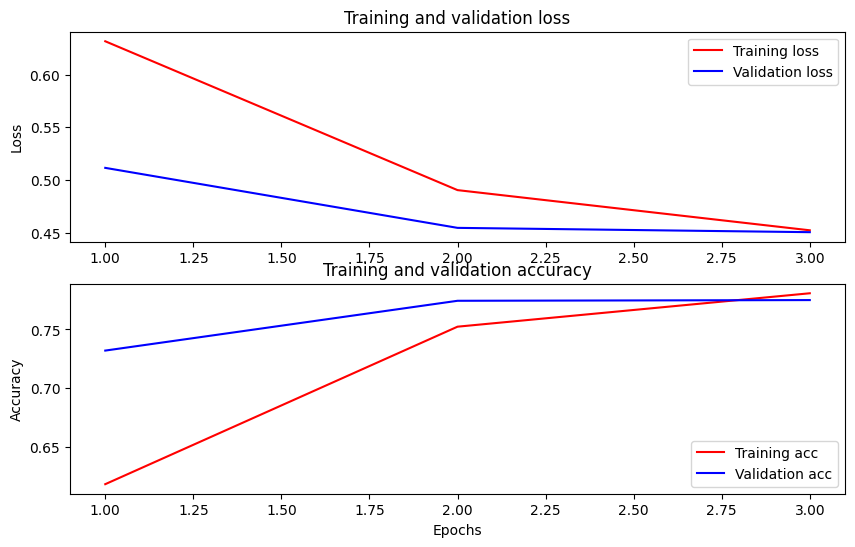

In [27]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy. Based on the plots above, we see a model accuracy of around 78-80% which is sufficient for this experiment.

## Containerization

### 1. Writing a `model.py` training script


In [46]:
MODEL_DIR = "bert-sentiment-classifier"

In [47]:
%%writefile {MODEL_DIR}/trainer/model.py
import os
import shutil
import logging

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization

DATA_URL = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
LOCAL_DATA_DIR = './tmp/data'
AUTOTUNE = tf.data.AUTOTUNE


def download_data(data_url, local_data_dir):
    """Download dataset.
    Args:
      data_url(str): Source data URL path.
      local_data_dir(str): Local data download directory path.
    Returns:
      dataset_dir(str): Local unpacked data directory path.
    """
    if not os.path.exists(local_data_dir):
        os.makedirs(local_data_dir)
    
    dataset = tf.keras.utils.get_file(
      fname='aclImdb_v1.tar.gz',
      origin=data_url,
      untar=True,
      cache_dir=local_data_dir,
      cache_subdir="")
    
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    
    train_dir = os.path.join(dataset_dir, 'train')
    
    # Remove unused folders to make it easier to load the data.
    remove_dir = os.path.join(train_dir, 'unsup')
    shutil.rmtree(remove_dir)
    
    return dataset_dir


def load_datasets(dataset_dir, hparams):
    """Load pre-split tf.datasets.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      raw_train_ds(tf.dataset): Train split dataset (20k examples).
      raw_val_ds(tf.dataset): Validation split dataset (5k examples).
      raw_test_ds(tf.dataset): Test split dataset (25k examples).
    """    

    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='training',
        seed=hparams['seed'])    

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='validation',
        seed=hparams['seed'])

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        batch_size=hparams['batch-size'])
    
    return raw_train_ds, raw_val_ds, raw_test_ds


def build_text_classifier(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      model(tf.keras.Model): A compiled TensorFlow model.
    """
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # TODO: Add a hub.KerasLayer for BERT text preprocessing using the hparams dict. 
    # Name the layer 'preprocessing' and store in the variable 'preprocessor'.
      
    encoder_inputs = preprocessor(text_input)
    # TODO: Add a trainable hub.KerasLayer for BERT text encoding using the hparams dict.
    # Name the layer 'BERT_encoder' and store in the variable 'encoder'.
      
    outputs = encoder(encoder_inputs)
    # For the fine-tuning you are going to use the `pooled_output` array which represents 
    # each input sequence as a whole. The shape is [batch_size, H]. 
    # You can think of this as an embedding for the entire movie review.
    classifier = outputs['pooled_output']
    # Add dropout to prevent overfitting during model fine-tuning.
    classifier = tf.keras.layers.Dropout(hparams['dropout'], name='dropout')(classifier)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier)
    model = tf.keras.Model(text_input, classifier, name='bert-sentiment-classifier')
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)    
    
    return model


def train_evaluate(hparams):
    """Train and evaluate TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    dataset_dir = download_data(data_url=DATA_URL, 
                                local_data_dir=LOCAL_DATA_DIR)
    
    raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(dataset_dir=dataset_dir,
                                                          hparams=hparams)
    
    train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)     
    
    epochs = hparams['epochs']
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    n_train_steps = steps_per_epoch * epochs
    n_warmup_steps = int(0.1 * n_train_steps)    
    
    optimizer = optimization.create_optimizer(init_lr=hparams['initial-learning-rate'],
                                              num_train_steps=n_train_steps,
                                              num_warmup_steps=n_warmup_steps,
                                              optimizer_type='adamw')    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = build_text_classifier(hparams=hparams, optimizer=optimizer)
        logging.info(model.summary())
        
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)  
    
    logging.info("Test accuracy: %s", model.evaluate(test_ds))

    # Export Keras model in TensorFlow SavedModel format.
    model.save(hparams['model-dir'])
    
    return history

Overwriting bert-sentiment-classifier/trainer/model.py


### 2. Writing a `task.py` file as an entrypoint to your custom model container

In [48]:
%%writefile {MODEL_DIR}/trainer/task.py

import os
import argparse

from trainer import model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    # Vertex custom container training args. These are set by Vertex AI during training but can also be overwritten.
    parser.add_argument('--model-dir', dest='model-dir',
                        default=os.environ['AIP_MODEL_DIR'], type=str, help='GCS URI for saving model artifacts.')

    # Model training args.
    parser.add_argument('--tfhub-bert-preprocessor', dest='tfhub-bert-preprocessor', 
                        default='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', type=str, help='TF-Hub URL.')
    parser.add_argument('--tfhub-bert-encoder', dest='tfhub-bert-encoder', 
                        default='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2', type=str, help='TF-Hub URL.')    
    parser.add_argument('--initial-learning-rate', dest='initial-learning-rate', default=3e-5, type=float, help='Learning rate for optimizer.')
    parser.add_argument('--epochs', dest='epochs', default=3, type=int, help='Training iterations.')    
    parser.add_argument('--batch-size', dest='batch-size', default=32, type=int, help='Number of examples during each training iteration.')    
    parser.add_argument('--dropout', dest='dropout', default=0.1, type=float, help='Float percentage of DNN nodes [0,1] to drop for regularization.')    
    parser.add_argument('--seed', dest='seed', default=42, type=int, help='Random number generator seed to prevent overlap between train and val sets.')
    
    args = parser.parse_args()
    hparams = args.__dict__

    model.train_evaluate(hparams)

Overwriting bert-sentiment-classifier/trainer/task.py


### 3. Write a `Dockerfile` for your custom model container

In [49]:
%%writefile {MODEL_DIR}/Dockerfile
# Specifies base image and tag.
# https://cloud.google.com/vertex-ai/docs/training/pre-built-containers
FROM us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-11:latest

# Sets the container working directory.
WORKDIR /root

# Copies the requirements.txt into the container to reduce network calls.
COPY requirements.txt .

# Installs additional packages.
RUN pip3 install -U -r requirements.txt

# b/203105209 Removes unneeded file from TF2.5 CPU image for python_module CustomJob training. 
# Will be removed on subsequent public Vertex images.
RUN rm -rf /var/sitecustomize/sitecustomize.py

# Copies the trainer code to the docker image.
COPY . /trainer

# Sets the container working directory.
WORKDIR /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.task"]

Overwriting bert-sentiment-classifier/Dockerfile


### 4. Writing a `requirements.txt` file to specify additional ML code dependencies

In [51]:
%%writefile {MODEL_DIR}/requirements.txt
tensorflow-hub==0.16.1
pandas>1.0.0
tfx==0.25.0
requests-toolbelt==0.10.1
google-cloud-aiplatform==1.22.0
tensorflow-text
tf-models-official
kfp==1.8.19
google_cloud_pipeline_components==1.0.39
google-api-core==2.11.0
googleapis-common-protos==1.58.0
grpcio-status==1.47.0
google-cloud-storage==2.7.0
google-cloud-resource-manager==1.8.1
google-cloud-bigquery==3.4.2
google-cloud-notebooks==1.6.1

Overwriting bert-sentiment-classifier/requirements.txt


## Using Cloud Build to build and submit the model container to Google Cloud Artifact Registry

### 1. Creating Artifact Registry for custom container images 


In [53]:
ARTIFACT_REGISTRY="bert-sentiment-classifier"

In [54]:

!gcloud artifacts repositories create "bert-sentiment-classifier" \
    --repository-format=docker \
    --location=europe-west1 \
    --description="Docker repository for storing container images" \
    --project="ml-deployments-practice"

ERROR: (gcloud.artifacts.repositories.create) ALREADY_EXISTS: the repository already exists


### 2. Creating `cloudbuild.yaml` instructions

In [55]:
IMAGE_NAME="bert-sentiment-classifier"
IMAGE_TAG="latest"
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY}/{IMAGE_NAME}:{IMAGE_TAG}"
print(IMAGE_URI)

europe-west1-docker.pkg.dev/ml-deployments-practice/bert-sentiment-classifier/bert-sentiment-classifier:latest


In [56]:
cloudbuild_yaml = f"""steps:
- name: 'gcr.io/cloud-builders/docker'
  args: [ 'build', '-t', '{IMAGE_URI}', '.' ]
images: 
- '{IMAGE_URI}'"""

with open(f"{MODEL_DIR}/cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

### 3. Building and submitting the container image to Artifact Registry using Cloud Build

In [57]:

!gcloud builds submit "bert-sentiment-classifier" \
    --config=bert-sentiment-classifier/cloudbuild.yaml \
    --timeout=1200s \
    --project="ml-deployments-practice"



----------------------------- REMOTE BUILD OUTPUT ------------------------------

Creating temporary tarball archive of 7 file(s) totalling 9.6 KiB before compression.

starting build "fa619da8-14b0-4dd9-afb0-a99a16371538"

Uploading tarball of [bert-sentiment-classifier] to [gs://ml-deployments-practice_cloudbuild/source/1718703874.082546-5abe042a46d547e784c32f11fb685ff3.tgz]


Created [https://cloudbuild.googleapis.com/v1/projects/ml-deployments-practice/locations/global/builds/fa619da8-14b0-4dd9-afb0-a99a16371538].

FETCHSOURCE

Logs are available at [ https://console.cloud.google.com/cloud-build/builds/fa619da8-14b0-4dd9-afb0-a99a16371538?project=785339747705 ].

Fetching storage object: gs://ml-deployments-practice_cloudbuild/source/1718703874.082546-5abe042a46d547e784c32f11fb685ff3.tgz#1718703875633645

BUILD FAILURE: Build step failure: build step 0 "gcr.io/cloud-builders/docker" failed: step exited with non-zero status: 1

Copying gs://ml-deployments-practice_cloudbuild/source/1718703874.082546-5abe042a46d547e784c32f11fb685ff3.tgz#1718703875633645...

ERROR: (gcloud.builds.submit) build fa619da8-14b0-4dd9-afb0-a99a16371538 completed with status "FAILURE"

/ [0 files][    0.0 B/  3.7 KiB]                                                


/ [1 files][  3.7 KiB/  3.7 KiB]                                                

Operation completed over 1 objects/3.7 KiB.
BUILD
Already have image (with digest): gcr.io/cloud-builders/docker
Sending build context to Docker daemon  17.41kB


Step 1/8 : FROM us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-11:latest
latest: Pulling from vertex-ai/training/tf-cpu.2-11
57c139bbda7e: Pulling fs layer
b36d8262105c: Pulling fs layer
6289371d2bb3: Pulling fs layer
481786a11c6e: Pulling fs layer
275a246fad1f: Pulling fs layer
6391690ddce2: Pulling fs layer
bbce0e9b489f: Pulling fs layer
a7ec0c7527b6: Pulling fs layer
7aff549e4c97: Pulling fs layer
4f4fb700ef54: Pulling fs layer
e4bff5ce614c: Pulling fs layer
2999545bd192: Pulling fs layer
bd33b5a5ec4a: Pulling fs layer
8fea5fa58717: Pulling fs layer
a73bd9480671: Pulling fs layer
139c41303dbe: Pulling fs layer
d7df78d5fe61: Pulling fs layer
7daa1f38b6ab: Pulling fs layer
bce9940ec07e: Pulling fs layer
01f79f64a163: Pulling fs layer
5113ced622

## Defining a pipeline using the KFP V2 SDK

In [58]:
!pip install urllib3==1.26.15 requests-toolbelt==0.10.1
import datetime
# google_cloud_pipeline_components includes pre-built KFP components for interfacing with Vertex AI services.
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import dsl



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
TIMESTAMP=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
DISPLAY_NAME = "bert-sentiment-{}".format(TIMESTAMP)
GCS_BASE_OUTPUT_DIR= f"{GCS_BUCKET}/{MODEL_DIR}-{TIMESTAMP}"

USER = ""  # TODO: change this to your name.
PIPELINE_ROOT = "{}/pipeline_root/{}".format(GCS_BUCKET, USER)

print(f"Model display name: {DISPLAY_NAME}")
print(f"GCS dir for model training artifacts: {GCS_BASE_OUTPUT_DIR}")
print(f"GCS dir for pipeline artifacts: {PIPELINE_ROOT}")

Model display name: bert-sentiment-20240618114655
GCS dir for model training artifacts: gs://vertex_test131412416/bert-sentiment-classifier-20240618114655
GCS dir for pipeline artifacts: gs://vertex_test131412416/pipeline_root/


In [60]:
# Pre-built Vertex model serving container for deployment.
# https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest"

The pipeline consists of three components:

* `CustomContainerTrainingJobRunOp` [(documentation)](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.CustomContainerTrainingJobRunOp): trains a custom model container using Vertex Training. 

*  `EndpointCreateOp` [(documentation)](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.EndpointCreateOp): Creates a Google Cloud Vertex Endpoint resource that maps physical machine resources with the model to enable it to serve online predictions. 

* `ModelDeployOp`[(documentation)](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.ModelDeployOp): deploys the model to a Vertex Prediction Endpoint for online predictions.

In [61]:
@dsl.pipeline(name="bert-sentiment-classification", pipeline_root=PIPELINE_ROOT)
def pipeline(
    project: str = PROJECT_ID,
    location: str = REGION,
    staging_bucket: str = GCS_BUCKET,
    display_name: str = DISPLAY_NAME,    
    container_uri: str = IMAGE_URI,
    model_serving_container_image_uri: str = SERVING_IMAGE_URI,    
    base_output_dir: str = GCS_BASE_OUTPUT_DIR,
):
    

    model_train_evaluate_op = gcc_aip.CustomContainerTrainingJobRunOp(
        # Vertex AI Python SDK authentication parameters.        
        project=project,
        location=location,
        staging_bucket=staging_bucket,
        display_name="bert-sentiment-classification",
        container_uri="europe-west1-docker.pkg.dev/ml-deployments-practice/bert-sentiment-classifier/bert-sentiment-classifier:latest",
        # WorkerPool arguments.
        replica_count=1,
        machine_type="e2-standard-4",
        # TODO: fill in the remaining arguments from the pipeline definition.

    )    
    
    # Create a Vertex Endpoint resource in parallel with model training.
    endpoint_create_op = gcc_aip.EndpointCreateOp(
        # Vertex AI Python SDK authentication parameters.
        project=project,
        location=location,
        display_name=display_name
    
    )   
    
    # Deploy your model to the created Endpoint resource for online predictions.
    model_deploy_op = gcc_aip.ModelDeployOp(
        # Link to model training component through output model artifact.
        model=model_train_evaluate_op.outputs["model"],
        # Link to the created Endpoint.
        endpoint=endpoint_create_op.outputs["endpoint"],
        # Define prediction request routing. {"0": 100} indicates 100% of traffic 
        # to the ID of the current model being deployed.
        traffic_split={"0": 100},
        # WorkerPool arguments.        
        dedicated_resources_machine_type="e2-standard-4",
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=2
    )

## Compile the pipeline

In [62]:
!pip install --upgrade kfp
from kfp.v2 import compiler

  Using cached kfp-2.7.0-py3-none-any.whl

  Using cached kfp_pipeline_spec-0.3.0-py3-none-any.whl (12 kB)

  Using cached kfp_server_api-2.0.5-py3-none-any.whl

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


google-cloud-pipeline-components 1.0.39 requires kfp<2.0.0,>=1.8.9, but you have kfp 2.7.0 which is incompatible.

google-cloud-pipeline-components 1.0.39 requires protobuf<4.0.0dev,>=3.19.0, but you have protobuf 4.25.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.0

[notice] To update, run: python.exe -m pip install --upgrade pip


  Attempting uninstall: kfp-pipeline-spec
    Found existing installation: kfp-pipeline-spec 0.1.16
    Uninstalling kfp-pipeline-spec-0.1.16:
      Successfully uninstalled kfp-pipeline-spec-0.1.16
  Attempting uninstall: kfp-server-api
    Found existing installation: kfp-server-api 1.8.5
    Uninstalling kfp-server-api-1.8.5:
      Successfully uninstalled kfp-server-api-1.8.5
  Attempting uninstall: kfp
    Found existing installation: kfp 1.8.19
    Uninstalling kfp-1.8.19:
      Successfully uninstalled kfp-1.8.19


In [63]:
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="bert-sentiment-classification.json"
)

## Running the pipeline on Vertex Pipelines

The `PipelineJob` is configured below and triggered through the `run()` method.


In [64]:
vertex_pipelines_job = vertexai.pipeline_jobs.PipelineJob(
    display_name="bert-sentiment-classification",
    template_path="bert-sentiment-classification.json",
    parameter_values={
        "project": PROJECT_ID,
        "location": REGION,
        "staging_bucket": GCS_BUCKET,
        "display_name": DISPLAY_NAME,        
        "container_uri": IMAGE_URI,
        "model_serving_container_image_uri": SERVING_IMAGE_URI,        
        "base_output_dir": GCS_BASE_OUTPUT_DIR},
    enable_caching=True,
)

In [ ]:
# Below fails due to the fact that the project has insufficient resources and I am a cheapskate
vertex_pipelines_job.run()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/bert-sentiment-classification-20240618114702?project=785339747705


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/bert-sentiment-classification-20240618114702?project=785339747705


PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/785339747705/locations/europe-west1/pipelineJobs/bert-sentiment-classification-20240618114702 current state:
PipelineState.PIPELINE_STATE_RUNNING


RuntimeError: Job failed with:
code: 9
message: "The DAG failed because some tasks failed. The failed tasks are: [endpoint-create, customcontainertrainingjob-run].; Job (project_id = ml-deployments-practice, job_id = 8783443140930437120) is failed due to the above error.; Failed to handle the job: {project_number = 785339747705, job_id = 8783443140930437120}"


## Querying deployed model on Vertex Endpoint for online predictions

In [ ]:

ENDPOINT_NAME = vertexai.Endpoint.list()[0].name

In [ ]:
endpoint = vertexai.Endpoint(
)

In [ ]:

test_review = ""

In [ ]:

prediction =

In [ ]:
print(prediction)

In [ ]:

print(tf.sigmoid(prediction.predictions[0]))